In [2]:
# Get the output data, save it as a table
import os
import pandas as pd
import matplotlib.pyplot as plt
from pydantic import BaseModel
import numpy as np
from ultralytics import YOLO

model = YOLO('yolov8n-pose.pt')
footage = 'videos/top_nonfatigue_pose_straight.MOV'
# results = model(footage)
results = model.predict(footage, save=False, conf=0.5)

output_name = 'training_data/1.csv'
fatigue_or_not = '0'

class GetKeypoint(BaseModel):
    NOSE:           int = 0
    LEFT_EYE:       int = 1
    RIGHT_EYE:      int = 2
    LEFT_EAR:       int = 3
    RIGHT_EAR:      int = 4
    LEFT_SHOULDER:  int = 5
    RIGHT_SHOULDER: int = 6
    LEFT_ELBOW:     int = 7
    RIGHT_ELBOW:    int = 8
    LEFT_WRIST:     int = 9
    RIGHT_WRIST:    int = 10
    LEFT_HIP:       int = 11
    RIGHT_HIP:      int = 12
    LEFT_KNEE:      int = 13
    RIGHT_KNEE:     int = 14
    LEFT_ANKLE:     int = 15
    RIGHT_ANKLE:    int = 16
        
class BodyKeypoints:
    def __init__(self, keypoints):
        get_keypoint = GetKeypoint()
        self.NOSE = keypoints[get_keypoint.NOSE]
        self.LEFT_EYE = keypoints[get_keypoint.LEFT_EYE]
        self.RIGHT_EYE = keypoints[get_keypoint.RIGHT_EYE]
        self.LEFT_EAR = keypoints[get_keypoint.LEFT_EAR]
        self.RIGHT_EAR = keypoints[get_keypoint.RIGHT_EAR]
        self.LEFT_SHOULDER = keypoints[get_keypoint.LEFT_SHOULDER]
        self.RIGHT_SHOULDER = keypoints[get_keypoint.RIGHT_SHOULDER]
        self.LEFT_ELBOW = keypoints[get_keypoint.LEFT_ELBOW]
        self.RIGHT_ELBOW = keypoints[get_keypoint.RIGHT_ELBOW]
        self.LEFT_WRIST = keypoints[get_keypoint.LEFT_WRIST]
        self.RIGHT_WRIST = keypoints[get_keypoint.RIGHT_WRIST]
        self.LEFT_HIP = keypoints[get_keypoint.LEFT_HIP]
        self.RIGHT_HIP = keypoints[get_keypoint.RIGHT_HIP]
        self.LEFT_KNEE = keypoints[get_keypoint.LEFT_KNEE]
        self.RIGHT_KNEE = keypoints[get_keypoint.RIGHT_KNEE]
        self.LEFT_ANKLE = keypoints[get_keypoint.LEFT_ANKLE]
        self.RIGHT_ANKLE = keypoints[get_keypoint.RIGHT_ANKLE]
        
def get_limbs_from_keypoints(keypoints: BodyKeypoints):
    limbs = {
        "right_eye&nose": [keypoints.RIGHT_EYE, keypoints.NOSE],
        "right_eye&right_ear": [keypoints.RIGHT_EYE, keypoints.RIGHT_EAR],
        "left_eye&nose": [keypoints.LEFT_EYE, keypoints.NOSE],
        "left_eye&left_ear": [keypoints.LEFT_EYE, keypoints.LEFT_EAR],
        "right_shoulder&right_elbow": [keypoints.RIGHT_SHOULDER, keypoints.RIGHT_ELBOW],
        "right_elbow&right_wrist": [keypoints.RIGHT_ELBOW, keypoints.RIGHT_WRIST],
        "left_shoulder&left_elbow": [keypoints.LEFT_SHOULDER, keypoints.LEFT_ELBOW],
        "left_elbow&left_wrist": [keypoints.LEFT_ELBOW, keypoints.LEFT_WRIST],
        "right_hip&right_knee": [keypoints.RIGHT_HIP, keypoints.RIGHT_KNEE],
        "right_knee&right_ankle": [keypoints.RIGHT_KNEE, keypoints.RIGHT_ANKLE],
        "left_hip&left_knee": [keypoints.LEFT_HIP, keypoints.LEFT_KNEE],
        "left_knee&left_ankle": [keypoints.LEFT_KNEE, keypoints.LEFT_ANKLE],
        "right_shoulder&left_shoulder": [keypoints.RIGHT_SHOULDER, keypoints.LEFT_SHOULDER],
        "right_hip&left_hip": [keypoints.RIGHT_HIP, keypoints.LEFT_HIP],
        "right_shoulder&right_hip": [keypoints.RIGHT_SHOULDER, keypoints.RIGHT_HIP],
        "left_shoulder&left_hip": [keypoints.LEFT_SHOULDER, keypoints.LEFT_HIP]
    }
    return limbs

body_keypoints_example = BodyKeypoints([[0,0]] * 17)
limbs = get_limbs_from_keypoints(body_keypoints_example)
def calculate_and_get_angles_as_dict(keypoints_coords, limbs):
    angle_information = {}
    
    for limb_1_name, limb_2_name in adjacent_limbs:
        limb_1 = limbs[limb_1_name]
        limb_2 = limbs[limb_2_name]
        
        common_point = None
        for point in limb_1:
            if any(np.array_equal(point, p) for p in limb_2):
                common_point = point
                break
        
        if common_point is None:
            continue
        
        vector_A = np.array(limb_1[1]) - np.array(limb_1[0]) if np.array_equal(limb_1[1], common_point) else np.array(limb_1[0]) - np.array(limb_1[1])
        vector_B = np.array(limb_2[1]) - np.array(limb_2[0]) if np.array_equal(limb_2[1], common_point) else np.array(limb_2[0]) - np.array(limb_2[1])
        
        angle = calculate_angle(vector_A, vector_B)
        key = f"{limb_1_name} - {KEYPOINT_LABELS[np.where((result_keypoint == common_point).all(axis=1))[0][0]]} - {limb_2_name}"
        value = f"{angle:.1f}°"
        
        angle_information[key] = value
        
    return angle_information

def find_closest_person_distance(prev_coordinates, current_coordinate):
    """
    Returns the index of the person from the previous frame whose coordinates 
    are closest to the current_coordinate and the corresponding distance.
    """
    distances = [(idx, np.linalg.norm(np.array(prev_coord) - np.array(current_coordinate)))
                 for idx, prev_coord in enumerate(prev_coordinates) if prev_coord is not None]
    if distances:
        min_distance_item = min(distances, key=lambda x: x[1])
        return min_distance_item
    return None, float('inf')

adjacent_limbs = []

selected_limbs = [
        "right_shoulder&right_elbow",
        "right_elbow&right_wrist",
        "left_shoulder&left_elbow",
        "left_elbow&left_wrist",
        "right_hip&right_knee",
        "right_knee&right_ankle",
        "left_hip&left_knee",
        "left_knee&left_ankle",
        "right_shoulder&left_shoulder",
        "right_hip&left_hip",
        "right_shoulder&right_hip",
        "left_shoulder&left_hip"
    ]

# Generating all possible combinations
for i in range(len(selected_limbs)):
    for j in range(i + 1, len(selected_limbs)):
        limb1 = limbs[selected_limbs[i]]
        limb2 = limbs[selected_limbs[j]]
        
        # Convert keypoints to tuples for comparison
        limb1_tuples = [tuple(point) for point in limb1]
        limb2_tuples = [tuple(point) for point in limb2]

        # Checking if any keypoint in the second limb matches with the keypoints in the first limb
        if any(kp in limb1_tuples for kp in limb2_tuples):
            adjacent_limbs.append((selected_limbs[i], selected_limbs[j]))

KEYPOINT_LABELS = [
    "NOSE", "LEFT_EYE", "RIGHT_EYE", "LEFT_EAR", "RIGHT_EAR", "LEFT_SHOULDER",
    "RIGHT_SHOULDER", "LEFT_ELBOW", "RIGHT_ELBOW", "LEFT_WRIST", "RIGHT_WRIST",
    "LEFT_HIP", "RIGHT_HIP", "LEFT_KNEE", "RIGHT_KNEE", "LEFT_ANKLE", "RIGHT_ANKLE"
]

angle_keys = [
    'right_shoulder&right_elbow - RIGHT_ELBOW - right_elbow&right_wrist',
    'right_shoulder&right_elbow - RIGHT_SHOULDER - right_shoulder&left_shoulder',
    'right_shoulder&right_elbow - RIGHT_SHOULDER - right_shoulder&right_hip',
    'left_shoulder&left_elbow - LEFT_ELBOW - left_elbow&left_wrist',
    'left_shoulder&left_elbow - LEFT_SHOULDER - right_shoulder&left_shoulder',
    'left_shoulder&left_elbow - LEFT_SHOULDER - left_shoulder&left_hip',
    'right_hip&right_knee - RIGHT_KNEE - right_knee&right_ankle',
    'right_hip&right_knee - RIGHT_HIP - right_hip&left_hip',
    'right_hip&right_knee - RIGHT_HIP - right_shoulder&right_hip',
    'left_hip&left_knee - LEFT_KNEE - left_knee&left_ankle',
    'left_hip&left_knee - LEFT_HIP - right_hip&left_hip',
    'left_hip&left_knee - LEFT_HIP - left_shoulder&left_hip',
    'right_shoulder&left_shoulder - RIGHT_SHOULDER - right_shoulder&right_hip',
    'right_shoulder&left_shoulder - LEFT_SHOULDER - left_shoulder&left_hip',
    'right_hip&left_hip - RIGHT_HIP - right_shoulder&right_hip',
    'right_hip&left_hip - LEFT_HIP - left_shoulder&left_hip'
]

def calculate_angle(A, B):
#     Calculate angle between two vectors A and B.
    dot_product = np.dot(A, B)
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)
    return np.arccos(dot_product / (norm_A * norm_B)) * (180/np.pi)



prev_person_coordinates = [None, None]  # Assuming at most two employees, initialize with None

# Create an empty DataFrame with the required columns
columns = ["Employee ID", "Frame", "Box x", "Box y", "Box width", "Box height", "Width-to-height ratio"] + angle_keys + ["Fatigue or not"]

# columns = ["Employee ID", "Frame", "Box x", "Box y", "Box width", "Box height", "Width-to-height ratio"] + [f"{keypoint} (x, y)" for keypoint in KEYPOINT_LABELS] + angle_keys + ["Fatigue or not"]

df = pd.DataFrame(columns=columns)

# Iterate through results to get bounding boxes and keypoints data
for idx, result in enumerate(results):
    keypoints_data = result.keypoints.xy.cpu().numpy() if hasattr(result, 'keypoints') else []
    boxes_data = result.boxes.xywh.cpu().numpy() if hasattr(result, 'boxes') else [] # Extract bounding boxes

    distances_and_indices = []

    # For each person, get the keypoints and determine which "employee" they match based on the nose's position
    for person_idx, result_keypoint in enumerate(keypoints_data):
        if len(result_keypoint) == 0:
            continue
        get_keypoint = GetKeypoint()
        nose_coordinate = tuple(result_keypoint[get_keypoint.NOSE])
        matched_person_idx, distance = find_closest_person_distance(prev_person_coordinates, nose_coordinate)
        distances_and_indices.append((distance, matched_person_idx, person_idx, result_keypoint))

    sorted_matches = sorted(distances_and_indices, key=lambda x: x[0])[:2]

    for distance, matched_person_idx, person_idx, result_keypoint in sorted_matches:
        if matched_person_idx is not None:
            prev_person_coordinates[matched_person_idx] = tuple(result_keypoint[get_keypoint.NOSE])

        body_keypoints = BodyKeypoints(result_keypoint)
        limbs = get_limbs_from_keypoints(body_keypoints)
        angle_info_dict = calculate_and_get_angles_as_dict(result_keypoint, limbs)

        # Construct the row data to be appended to the DataFrame
        row_data = {
            "Employee ID": person_idx + 1,
            "Frame": idx + 1,
        }
#         for label, keypoint in zip(KEYPOINT_LABELS, result_keypoint):
#             row_data[f"{label} (x, y)"] = tuple(keypoint)
        for angle_key in angle_keys:
            angle_value = angle_info_dict.get(angle_key, None)
            if angle_value:
                angle_value = ''.join([char for char in angle_value if char.isdigit() or char == '.'])
            row_data[angle_key] = angle_value

        # Include bounding box data for this person
        box = boxes_data[person_idx] if len(boxes_data) > person_idx else [None, None, None, None]
        # row_data["Bounding Box (x, y, w, h)"] = tuple(box)
        row_data["Box x"] = box[0] # The YOLO model frames the object in a box, and x refers to the x-coordinate of the diagonal intersection (geometric center) of the box.
        row_data["Box y"] = box[1]
        row_data["Box width"] = box[2]
        row_data["Box height"] = box[3]
        row_data["Width-to-height ratio"] = box[2]/box[3] # The width-to-height ratio of the box
        

        row_data['Fatigue or not'] = fatigue_or_not

        # Append the data to the DataFrame
        df = df.append(row_data, ignore_index=True)
#         df.iloc[-1]

# Print out the table representation
print(df)
# save DataFrame to a CSV file
df.to_csv(output_name, index=False)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 136.3ms
video 1/1 (2/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 118.3ms
video 1/1 (3/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 114.7ms
video 1/1 (4

video 1/1 (53/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 75.9ms
video 1/1 (54/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 75.7ms
video 1/1 (55/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 73.4ms
video 1/1 (56/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 74.8ms
video 1/1 (57/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 82.5ms
video 1/1 (58/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 82.8ms
video 1/1 (59/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_stra

video 1/1 (109/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 64.7ms
video 1/1 (110/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 129.7ms
video 1/1 (111/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 61.6ms
video 1/1 (112/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 327.3ms
video 1/1 (113/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 67.0ms
video 1/1 (114/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 60.0ms
video 1/1 (115/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_

video 1/1 (164/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 108.8ms
video 1/1 (165/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 111.8ms
video 1/1 (166/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 113.4ms
video 1/1 (167/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 90.7ms
video 1/1 (168/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 104.9ms
video 1/1 (169/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 100.6ms
video 1/1 (170/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatig

video 1/1 (219/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 93.1ms
video 1/1 (220/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 94.2ms
video 1/1 (221/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 96.7ms
video 1/1 (222/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 147.7ms
video 1/1 (223/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 81.2ms
video 1/1 (224/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 103.3ms
video 1/1 (225/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_

video 1/1 (275/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 1 person, 95.2ms
video 1/1 (276/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 1 person, 114.7ms
video 1/1 (277/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 1 person, 88.7ms
video 1/1 (278/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 1 person, 94.0ms
video 1/1 (279/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 1 person, 97.9ms
video 1/1 (280/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 1 person, 85.2ms
video 1/1 (281/328) /Users/macbook/Desktop/Codespace/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_st

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

    Employee ID Frame   Box x  Box y  Box width  Box height  \
0             1     1  1201.5  272.5      125.0       323.0   
1             2     1  1079.5  336.5      127.0       403.0   
2             1     2  1201.0  271.5      126.0       321.0   
3             2     2  1080.0  337.5      128.0       405.0   
4             1     3  1201.0  270.5      126.0       319.0   
..          ...   ...     ...    ...        ...         ...   
607           2   326   716.5  679.0      313.0       620.0   
608           1   327   207.0  778.0      414.0       548.0   
609           2   327   720.5  680.5      311.0       619.0   
610           1   328   209.5  778.0      419.0       554.0   
611           2   328   727.0  685.5      306.0       619.0   

     Width-to-height ratio  \
0                 0.386997   
1                 0.315136   
2                 0.392523   
3                 0.316049   
4                 0.394984   
..                     ...   
607               0.504839   
608

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_84248/3157544721.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

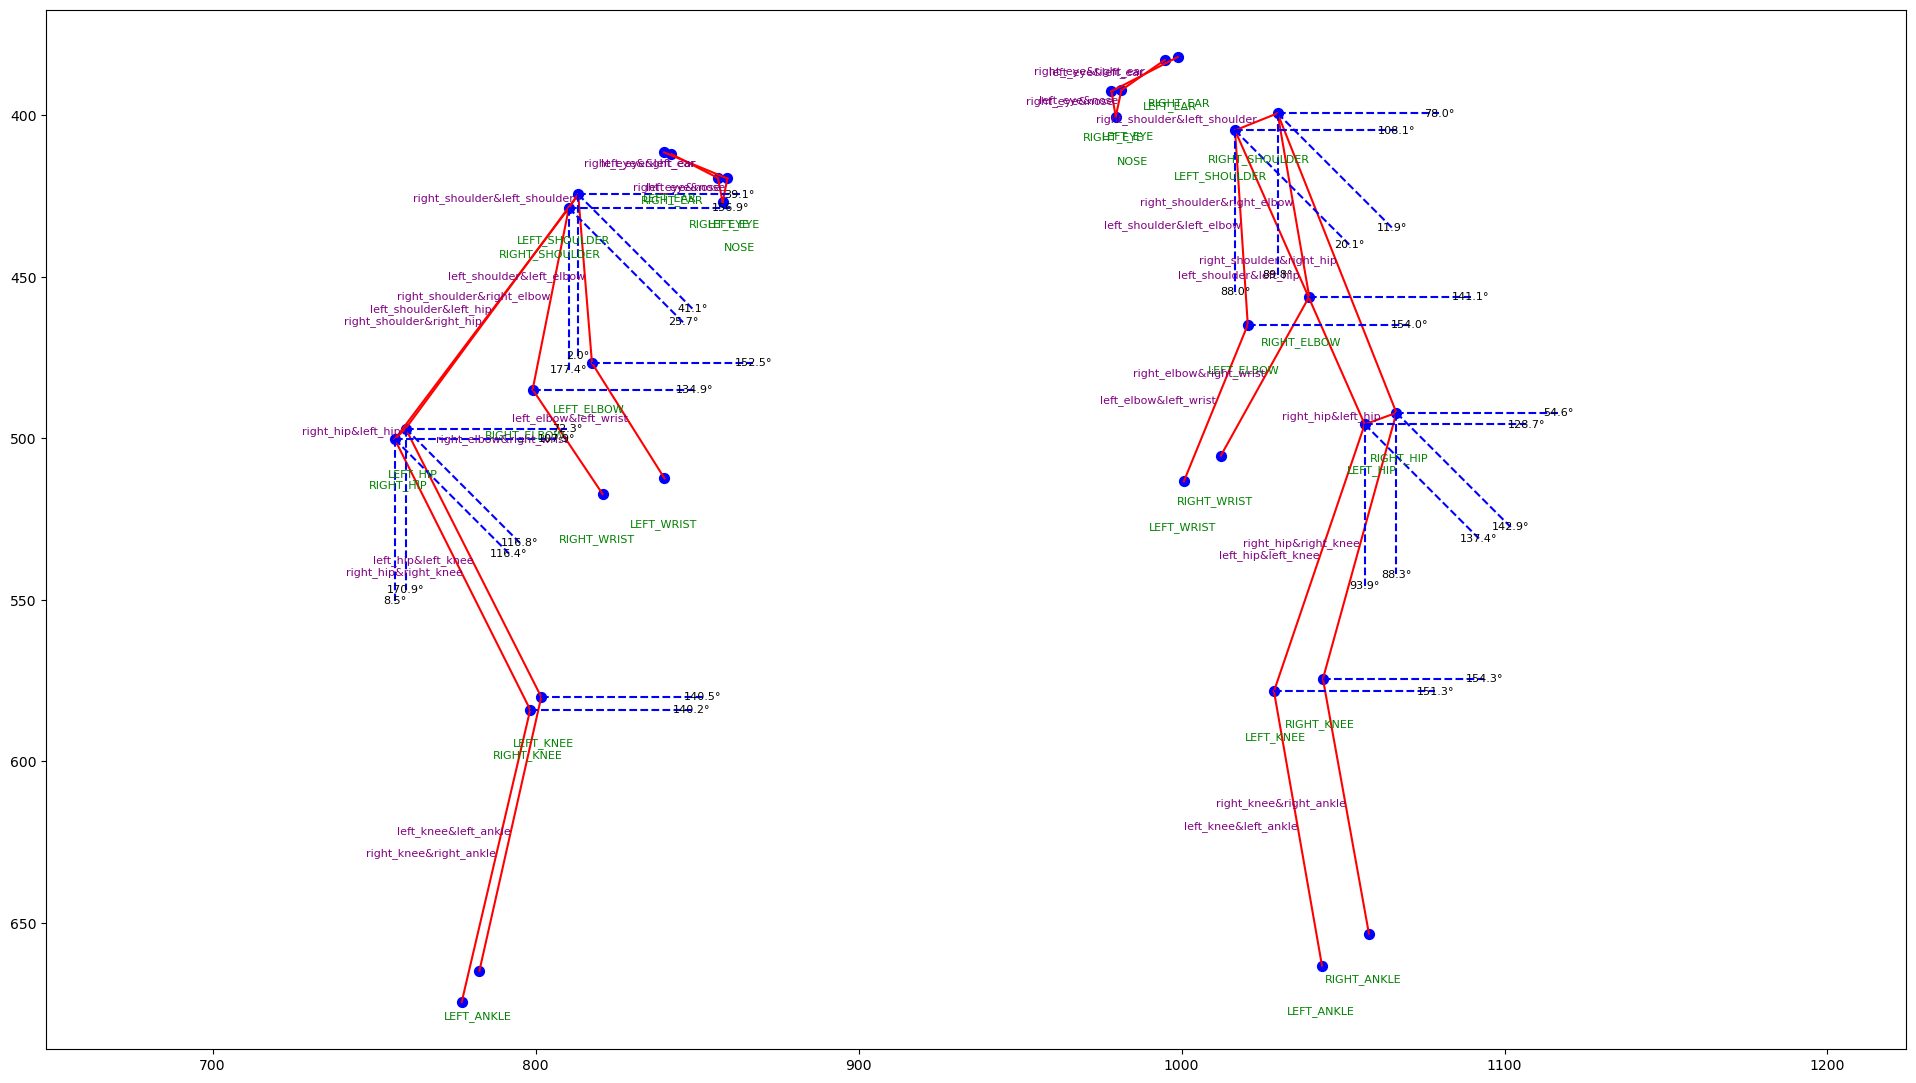

In [6]:
# This function is used to generate information about two workers at the same time
def plot_keypoints_with_multiple_datasets(keypoints_datasets, limbs_template):
# By default, the DPI (dots per inch) in Matplotlib is set to 80. So, to get a figure of size 1920x1080, 
# we can set the width to 24 inches (1920/80) and the height to 13.5 inches (1080/80).
    plt.figure(figsize=(24, 13.5))
    POINT_LABEL_COLOR = 'green'
    LINE_LABEL_COLOR = 'purple'
    INDICATOR_LINE_COLOR = 'orange'
    ANGLE_INDICATOR_LINE_COLOR = 'blue'
    ANGLE_LABEL_COLOR = 'black'
    OFFSET_ANGLES = [0, 45, 90, 135, 180, 225, 270, 315]

    for keypoints_coords in keypoints_datasets:
        # Extract limbs based on current keypoints
        body_keypoints = BodyKeypoints(keypoints_coords)
        limbs = get_limbs_from_keypoints(body_keypoints)

        # Draw key points
        for idx, keypoint in enumerate(keypoints_coords):
            plt.scatter(*keypoint, s=50, color='blue')
            label_position = (keypoint[0] + 10, keypoint[1] + 15)
            plt.annotate(KEYPOINT_LABELS[idx], label_position, fontsize=8, ha='right', color=POINT_LABEL_COLOR)

        # Draw lines and add labels
        for limb_name, limb in limbs.items():
            x_values = [limb[0][0], limb[1][0]]
            y_values = [limb[0][1], limb[1][1]]
            plt.plot(x_values, y_values, 'r-')

            mid_x = sum(x_values) / 2
            mid_y = sum(y_values) / 2
            offset = 0.02
            indicator_end_x = mid_x + offset
            indicator_end_y = mid_y + offset
            plt.plot([mid_x, indicator_end_x], [mid_y, indicator_end_y], '--', color=INDICATOR_LINE_COLOR)
            plt.annotate(limb_name, (indicator_end_x, indicator_end_y), fontsize=8, ha='right', color=LINE_LABEL_COLOR)

        angle_offsets = {}

        # Calculate and annotate angles for adjacent limbs
        for limb_1_name, limb_2_name in adjacent_limbs:
            limb_1 = limbs[limb_1_name]
            limb_2 = limbs[limb_2_name]
            
            common_point = None
            for point in limb_1:
                if any(np.array_equal(point, p) for p in limb_2):
                    common_point = np.array(point)
                    break

            if common_point is None:
                continue

            # Get vector A and B
            vector_A = np.array(limb_1[1]) - np.array(limb_1[0]) if np.array_equal(limb_1[1], common_point) else np.array(limb_1[0]) - np.array(limb_1[1])
            vector_B = np.array(limb_2[1]) - np.array(limb_2[0]) if np.array_equal(limb_2[1], common_point) else np.array(limb_2[0]) - np.array(limb_2[1])

            angle = calculate_angle(vector_A, vector_B)

            # Determine the offset for multiple angles at the same point
            if common_point.tobytes() not in angle_offsets:
                angle_offsets[common_point.tobytes()] = 0
            else:
                angle_offsets[common_point.tobytes()] += 1

            offset_angle = OFFSET_ANGLES[angle_offsets[common_point.tobytes()] % len(OFFSET_ANGLES)]
            offset_dx = 50 * np.cos(np.radians(offset_angle))
            offset_dy = 50 * np.sin(np.radians(offset_angle))

            end_point = common_point + np.array([offset_dx, offset_dy])

            plt.plot([common_point[0], end_point[0]], [common_point[1], end_point[1]], linestyle='--', color=ANGLE_INDICATOR_LINE_COLOR)
            plt.annotate(f"{angle:.1f}°", end_point, fontsize=8, ha='center', va='center', color=ANGLE_LABEL_COLOR)

    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()

keypoints_data = results[0].keypoints.xy.cpu().numpy()
datasets_to_plot = [keypoints_data[i] for i in range(len(keypoints_data))]
plot_keypoints_with_multiple_datasets(datasets_to_plot, limbs)

# for idx in range(len(keypoints_data)):
#     print("NO.%d person detected: " %(idx+1))
#     result_keypoint = keypoints_data[idx]
#     print(result_keypoint)
#     body_keypoints = BodyKeypoints(result_keypoint)
#     limbs = get_limbs_from_keypoints(body_keypoints)
#     angle_info_dict = calculate_and_get_angles_as_dict(result_keypoint, limbs)
#     print(angle_info_dict)

In [23]:
results = model.predict(footage, save=True, conf=0.5)

for result in results:
    boxes = result.boxes.xywh.cpu().numpy()  # Boxes object for bbox outputs
    print(boxes)


image 1/1 /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/images/frame_1.jpg: 384x640 2 persons, 97.6ms
Speed: 4.8ms preprocess, 97.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/pose/predict2


[[        803         539         150         322]
 [       1023       519.5         130         337]]


In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pydantic import BaseModel
import numpy as np
from ultralytics import YOLO

def process_video(footage, output_name, fatigue_or_not):
    model = YOLO('yolov8n-pose.pt')
    results = model.predict(footage, save=False, conf=0.5)

    class GetKeypoint(BaseModel):
        NOSE:           int = 0
        LEFT_EYE:       int = 1
        RIGHT_EYE:      int = 2
        LEFT_EAR:       int = 3
        RIGHT_EAR:      int = 4
        LEFT_SHOULDER:  int = 5
        RIGHT_SHOULDER: int = 6
        LEFT_ELBOW:     int = 7
        RIGHT_ELBOW:    int = 8
        LEFT_WRIST:     int = 9
        RIGHT_WRIST:    int = 10
        LEFT_HIP:       int = 11
        RIGHT_HIP:      int = 12
        LEFT_KNEE:      int = 13
        RIGHT_KNEE:     int = 14
        LEFT_ANKLE:     int = 15
        RIGHT_ANKLE:    int = 16

    class BodyKeypoints:
        def __init__(self, keypoints):
            get_keypoint = GetKeypoint()
            self.NOSE = keypoints[get_keypoint.NOSE]
            self.LEFT_EYE = keypoints[get_keypoint.LEFT_EYE]
            self.RIGHT_EYE = keypoints[get_keypoint.RIGHT_EYE]
            self.LEFT_EAR = keypoints[get_keypoint.LEFT_EAR]
            self.RIGHT_EAR = keypoints[get_keypoint.RIGHT_EAR]
            self.LEFT_SHOULDER = keypoints[get_keypoint.LEFT_SHOULDER]
            self.RIGHT_SHOULDER = keypoints[get_keypoint.RIGHT_SHOULDER]
            self.LEFT_ELBOW = keypoints[get_keypoint.LEFT_ELBOW]
            self.RIGHT_ELBOW = keypoints[get_keypoint.RIGHT_ELBOW]
            self.LEFT_WRIST = keypoints[get_keypoint.LEFT_WRIST]
            self.RIGHT_WRIST = keypoints[get_keypoint.RIGHT_WRIST]
            self.LEFT_HIP = keypoints[get_keypoint.LEFT_HIP]
            self.RIGHT_HIP = keypoints[get_keypoint.RIGHT_HIP]
            self.LEFT_KNEE = keypoints[get_keypoint.LEFT_KNEE]
            self.RIGHT_KNEE = keypoints[get_keypoint.RIGHT_KNEE]
            self.LEFT_ANKLE = keypoints[get_keypoint.LEFT_ANKLE]
            self.RIGHT_ANKLE = keypoints[get_keypoint.RIGHT_ANKLE]

    def get_limbs_from_keypoints(keypoints: BodyKeypoints):
        limbs = {
            "right_eye&nose": [keypoints.RIGHT_EYE, keypoints.NOSE],
            "right_eye&right_ear": [keypoints.RIGHT_EYE, keypoints.RIGHT_EAR],
            "left_eye&nose": [keypoints.LEFT_EYE, keypoints.NOSE],
            "left_eye&left_ear": [keypoints.LEFT_EYE, keypoints.LEFT_EAR],
            "right_shoulder&right_elbow": [keypoints.RIGHT_SHOULDER, keypoints.RIGHT_ELBOW],
            "right_elbow&right_wrist": [keypoints.RIGHT_ELBOW, keypoints.RIGHT_WRIST],
            "left_shoulder&left_elbow": [keypoints.LEFT_SHOULDER, keypoints.LEFT_ELBOW],
            "left_elbow&left_wrist": [keypoints.LEFT_ELBOW, keypoints.LEFT_WRIST],
            "right_hip&right_knee": [keypoints.RIGHT_HIP, keypoints.RIGHT_KNEE],
            "right_knee&right_ankle": [keypoints.RIGHT_KNEE, keypoints.RIGHT_ANKLE],
            "left_hip&left_knee": [keypoints.LEFT_HIP, keypoints.LEFT_KNEE],
            "left_knee&left_ankle": [keypoints.LEFT_KNEE, keypoints.LEFT_ANKLE],
            "right_shoulder&left_shoulder": [keypoints.RIGHT_SHOULDER, keypoints.LEFT_SHOULDER],
            "right_hip&left_hip": [keypoints.RIGHT_HIP, keypoints.LEFT_HIP],
            "right_shoulder&right_hip": [keypoints.RIGHT_SHOULDER, keypoints.RIGHT_HIP],
            "left_shoulder&left_hip": [keypoints.LEFT_SHOULDER, keypoints.LEFT_HIP]
        }
        return limbs

    body_keypoints_example = BodyKeypoints([[0,0]] * 17)
    limbs = get_limbs_from_keypoints(body_keypoints_example)
    def calculate_and_get_angles_as_dict(keypoints_coords, limbs):
        angle_information = {}

        for limb_1_name, limb_2_name in adjacent_limbs:
            limb_1 = limbs[limb_1_name]
            limb_2 = limbs[limb_2_name]

            common_point = None
            for point in limb_1:
                if any(np.array_equal(point, p) for p in limb_2):
                    common_point = point
                    break

            if common_point is None:
                continue

            vector_A = np.array(limb_1[1]) - np.array(limb_1[0]) if np.array_equal(limb_1[1], common_point) else np.array(limb_1[0]) - np.array(limb_1[1])
            vector_B = np.array(limb_2[1]) - np.array(limb_2[0]) if np.array_equal(limb_2[1], common_point) else np.array(limb_2[0]) - np.array(limb_2[1])

            angle = calculate_angle(vector_A, vector_B)
            if isinstance(angle, str):  # Handle the string return value
                value = angle
            else:
                value = f"{angle:.1f}°"
                
            key = f"{limb_1_name} - {KEYPOINT_LABELS[np.where((result_keypoint == common_point).all(axis=1))[0][0]]} - {limb_2_name}"

            angle_information[key] = value

        return angle_information

    def find_closest_person_distance(prev_coordinates, current_coordinate):
        """
        Returns the index of the person from the previous frame whose coordinates 
        are closest to the current_coordinate and the corresponding distance.
        """
        distances = [(idx, np.linalg.norm(np.array(prev_coord) - np.array(current_coordinate)))
                     for idx, prev_coord in enumerate(prev_coordinates) if prev_coord is not None]
        if distances:
            min_distance_item = min(distances, key=lambda x: x[1])
            return min_distance_item
        return None, float('inf')

    adjacent_limbs = []

    selected_limbs = [
            "right_shoulder&right_elbow",
            "right_elbow&right_wrist",
            "left_shoulder&left_elbow",
            "left_elbow&left_wrist",
            "right_hip&right_knee",
            "right_knee&right_ankle",
            "left_hip&left_knee",
            "left_knee&left_ankle",
            "right_shoulder&left_shoulder",
            "right_hip&left_hip",
            "right_shoulder&right_hip",
            "left_shoulder&left_hip"
        ]

    # Generating all possible combinations
    for i in range(len(selected_limbs)):
        for j in range(i + 1, len(selected_limbs)):
            limb1 = limbs[selected_limbs[i]]
            limb2 = limbs[selected_limbs[j]]

            # Convert keypoints to tuples for comparison
            limb1_tuples = [tuple(point) for point in limb1]
            limb2_tuples = [tuple(point) for point in limb2]

            # Checking if any keypoint in the second limb matches with the keypoints in the first limb
            if any(kp in limb1_tuples for kp in limb2_tuples):
                adjacent_limbs.append((selected_limbs[i], selected_limbs[j]))

    KEYPOINT_LABELS = [
        "NOSE", "LEFT_EYE", "RIGHT_EYE", "LEFT_EAR", "RIGHT_EAR", "LEFT_SHOULDER",
        "RIGHT_SHOULDER", "LEFT_ELBOW", "RIGHT_ELBOW", "LEFT_WRIST", "RIGHT_WRIST",
        "LEFT_HIP", "RIGHT_HIP", "LEFT_KNEE", "RIGHT_KNEE", "LEFT_ANKLE", "RIGHT_ANKLE"
    ]

    angle_keys = [
        'right_shoulder&right_elbow - RIGHT_ELBOW - right_elbow&right_wrist',
        'right_shoulder&right_elbow - RIGHT_SHOULDER - right_shoulder&left_shoulder',
        'right_shoulder&right_elbow - RIGHT_SHOULDER - right_shoulder&right_hip',
        'left_shoulder&left_elbow - LEFT_ELBOW - left_elbow&left_wrist',
        'left_shoulder&left_elbow - LEFT_SHOULDER - right_shoulder&left_shoulder',
        'left_shoulder&left_elbow - LEFT_SHOULDER - left_shoulder&left_hip',
        'right_hip&right_knee - RIGHT_KNEE - right_knee&right_ankle',
        'right_hip&right_knee - RIGHT_HIP - right_hip&left_hip',
        'right_hip&right_knee - RIGHT_HIP - right_shoulder&right_hip',
        'left_hip&left_knee - LEFT_KNEE - left_knee&left_ankle',
        'left_hip&left_knee - LEFT_HIP - right_hip&left_hip',
        'left_hip&left_knee - LEFT_HIP - left_shoulder&left_hip',
        'right_shoulder&left_shoulder - RIGHT_SHOULDER - right_shoulder&right_hip',
        'right_shoulder&left_shoulder - LEFT_SHOULDER - left_shoulder&left_hip',
        'right_hip&left_hip - RIGHT_HIP - right_shoulder&right_hip',
        'right_hip&left_hip - LEFT_HIP - left_shoulder&left_hip'
    ]

    def calculate_angle(A, B):
        """
        Calculate angle between two vectors A and B.
        Return the angle in degrees or 'N/A' for invalid angles or angles close to 0.
        """
        # Calculate the dot product
        dot_product = np.dot(A, B)

        # Calculate the magnitudes of vectors A and B
        norm_A = np.linalg.norm(A)
        norm_B = np.linalg.norm(B)

        # Check if norms are zero or close to zero
        if np.isclose(norm_A, 0) or np.isclose(norm_B, 0):
            return np.nan

        # Calculate the cosine of the angle
        cosine_angle = dot_product / (norm_A * norm_B)

        # Check for potential floating-point errors causing cosine_angle to be slightly > 1 or < -1
        cosine_angle = np.clip(cosine_angle, -1.0, 1.0)

        # Convert from radians to degrees
        angle_degrees = np.arccos(cosine_angle) * (180/np.pi)

        # Check if the angle is approximately 0
        if np.isclose(angle_degrees, 0):
            return np.nan

        return angle_degrees


    prev_person_coordinates = [None, None]  # Assuming at most two employees, initialize with None

    # Create an empty DataFrame with the required columns
    columns = ["Employee ID", "Frame", "Box x", "Box y", "Box width", "Box height", "Width-to-height ratio"] + angle_keys + ["Fatigue or not"]
    # columns = ["Employee ID", "Frame", "Box x", "Box y", "Box width", "Box height", "Width-to-height ratio"] + [f"{keypoint} (x, y)" for keypoint in KEYPOINT_LABELS] + angle_keys + ["Fatigue or not"]
    
    df = pd.DataFrame(columns=columns)
    
    # Iterate through results to get bounding boxes and keypoints data
    for idx, result in enumerate(results):
        keypoints_data = result.keypoints.xy.cpu().numpy() if hasattr(result, 'keypoints') else []
        boxes_data = result.boxes.xywh.cpu().numpy() if hasattr(result, 'boxes') else [] # Extract bounding boxes

        distances_and_indices = []

        # For each person, get the keypoints and determine which "employee" they match based on the nose's position
        for person_idx, result_keypoint in enumerate(keypoints_data):
            if len(result_keypoint) == 0:
                continue
            get_keypoint = GetKeypoint()
            nose_coordinate = tuple(result_keypoint[get_keypoint.NOSE])
            matched_person_idx, distance = find_closest_person_distance(prev_person_coordinates, nose_coordinate)
            distances_and_indices.append((distance, matched_person_idx, person_idx, result_keypoint))

        sorted_matches = sorted(distances_and_indices, key=lambda x: x[0])[:2]

        for distance, matched_person_idx, person_idx, result_keypoint in sorted_matches:
            if matched_person_idx is not None:
                prev_person_coordinates[matched_person_idx] = tuple(result_keypoint[get_keypoint.NOSE])

            body_keypoints = BodyKeypoints(result_keypoint)
            limbs = get_limbs_from_keypoints(body_keypoints)
            angle_info_dict = calculate_and_get_angles_as_dict(result_keypoint, limbs)

            # Construct the row data to be appended to the DataFrame
            row_data = {
                "Employee ID": person_idx + 1,
                "Frame": idx + 1,
            }
    #         for label, keypoint in zip(KEYPOINT_LABELS, result_keypoint):
    #             row_data[f"{label} (x, y)"] = tuple(keypoint)
            for angle_key in angle_keys:
                angle_value = angle_info_dict.get(angle_key, None)
                if angle_value:
                    angle_value = ''.join([char for char in angle_value if char.isdigit() or char == '.'])
                row_data[angle_key] = angle_value

            # Include bounding box data for this person
            box = boxes_data[person_idx] if len(boxes_data) > person_idx else [None, None, None, None]
            # row_data["Bounding Box (x, y, w, h)"] = tuple(box)
            
            # The YOLO model provides a bounding box around detected objects. The 'x' value specifically refers to the x-coordinate of the center point of this bounding box. 
            # In other words, 'x' is the horizontal coordinate of the point that lies equidistant from the left and right sides of the box.
            row_data["Box x"] = box[0]
            # 'box[1]' refers to the y-coordinate of the center of the bounding box around the detected object.
            # This is the vertical coordinate of the point that lies equidistant from the top and bottom sides of the box.
            row_data["Box y"] = box[1]
            # 'box[2]' denotes the width of the bounding box. 
            # It represents the horizontal distance or span across the detected object from its leftmost to its rightmost edge.
            row_data["Box width"] = box[2]
            # 'box[3]' stands for the height of the bounding box.
            # It measures the vertical distance or span across the detected object from its topmost to its bottommost edge.
            row_data["Box height"] = box[3]
            # This calculates the ratio of the width of the bounding box to its height.
            # A value greater than 1 implies the box is wider than it is tall, while a value less than 1 indicates the box is taller than it is wide.
            row_data["Width-to-height ratio"] = box[2]/box[3]

            row_data['Fatigue or not'] = fatigue_or_not

            # Append the data to the DataFrame
            df = df.append(row_data, ignore_index=True)

    # Print out the table representation
    print(df)
    # save DataFrame to a CSV file
    df.to_csv(output_name, index=False)

# List all .MOV files in the 'videos' directory
video_files = [f for f in os.listdir('videos') if f.endswith('.MOV')]

# Process each video
for video_file in video_files:
    footage = os.path.join('videos', video_file)
    output_name = os.path.join('training_data', video_file.replace('.MOV', '.csv'))

    # Determine the 'fatigue_or_not' value based on the video filename
    if "nonfatigue" in video_file:
        fatigue_or_not = '0'
    elif "fatigue" in video_file:
        fatigue_or_not = '1'
    else:
        # Handle other cases, if any
        print(f"Warning: Couldn't determine fatigue status for video '{video_file}'. Skipping.")
        continue
        
    # Process the video
    process_video(footage, output_name, fatigue_or_not)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 127.5ms
video 1/1 (2/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 116.7ms
video 1/1 (3/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 112.5ms
video 1/1 (4/450) /Users/macbook/Deskto

video 1/1 (56/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 90.1ms
video 1/1 (57/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 1 person, 113.5ms
video 1/1 (58/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 1 person, 96.8ms
video 1/1 (59/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 110.3ms
video 1/1 (60/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 108.6ms
video 1/1 (61/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 89.9ms
video 1/1 (62/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 60.8ms
video 1/1 (63/450) /Users/

video 1/1 (115/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 87.8ms
video 1/1 (116/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 97.3ms
video 1/1 (117/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 96.6ms
video 1/1 (118/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 100.0ms
video 1/1 (119/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 92.1ms
video 1/1 (120/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 97.9ms
video 1/1 (121/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 81.3ms
video 1/1 (122/450)

video 1/1 (174/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 78.9ms
video 1/1 (175/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 72.4ms
video 1/1 (176/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 68.0ms
video 1/1 (177/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 71.3ms
video 1/1 (178/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 75.5ms
video 1/1 (179/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 75.4ms
video 1/1 (180/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 77.6ms
video 1/1 (181/450) 

video 1/1 (233/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 87.6ms
video 1/1 (234/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 112.3ms
video 1/1 (235/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 93.6ms
video 1/1 (236/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 89.6ms
video 1/1 (237/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 89.6ms
video 1/1 (238/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 85.4ms
video 1/1 (239/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 83.7ms
video 1/1 (240/450)

video 1/1 (292/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 103.9ms
video 1/1 (293/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 91.7ms
video 1/1 (294/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 84.6ms
video 1/1 (295/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 113.5ms
video 1/1 (296/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 93.0ms
video 1/1 (297/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 142.1ms
video 1/1 (298/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 72.5ms
video 1/1 (299/45

video 1/1 (351/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 93.0ms
video 1/1 (352/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 90.3ms
video 1/1 (353/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 85.7ms
video 1/1 (354/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 89.9ms
video 1/1 (355/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 99.0ms
video 1/1 (356/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 123.2ms
video 1/1 (357/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 74.6ms
video 1/1 (358/450)

video 1/1 (410/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 (no detections), 97.9ms
video 1/1 (411/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 1 person, 91.8ms
video 1/1 (412/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 96.8ms
video 1/1 (413/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 87.1ms
video 1/1 (414/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 3 persons, 96.9ms
video 1/1 (415/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 109.9ms
video 1/1 (416/450) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_straight.MOV: 384x640 2 persons, 86.1ms
video 1/1 (417

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

    Employee ID Frame   Box x  Box y  Box width  Box height  \
0             1     1   999.5  368.5      163.0       429.0   
1             2     1  1174.5  292.0      115.0       374.0   
2             1     2  1002.0  369.0      168.0       428.0   
3             2     2  1175.0  292.0      116.0       374.0   
4             1     3  1001.0  369.5      166.0       425.0   
..          ...   ...     ...    ...        ...         ...   
854           1   446   608.5  624.0      325.0       530.0   
855           1   447   608.5  623.0      325.0       530.0   
856           1   448   608.5  624.0      325.0       532.0   
857           1   449   608.5  623.5      325.0       533.0   
858           1   450   610.0  621.0      326.0       528.0   

     Width-to-height ratio  \
0                 0.379953   
1                 0.307487   
2                 0.392523   
3                 0.310160   
4                 0.390588   
..                     ...   
854               0.613208   
855



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 116.3ms
video 1/1 (2/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 94.7ms
video 1/1 (3/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 99.0ms
video 1/1 (4/389) /User

video 1/1 (54/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 86.7ms
video 1/1 (55/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 91.6ms
video 1/1 (56/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 92.8ms
video 1/1 (57/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 94.3ms
video 1/1 (58/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 89.5ms
video 1/1 (59/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 86.9ms
video 1/1 (60/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 p

video 1/1 (111/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 83.6ms
video 1/1 (112/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 113.4ms
video 1/1 (113/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 99.5ms
video 1/1 (114/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 93.0ms
video 1/1 (115/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 119.1ms
video 1/1 (116/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 130.1ms
video 1/1 (117/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 3

video 1/1 (167/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 115.1ms
video 1/1 (168/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 98.5ms
video 1/1 (169/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 96.7ms
video 1/1 (170/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 110.2ms
video 1/1 (171/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 104.9ms
video 1/1 (172/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 110.7ms
video 1/1 (173/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 

video 1/1 (223/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 104.4ms
video 1/1 (224/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 83.4ms
video 1/1 (225/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 97.2ms
video 1/1 (226/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 111.3ms
video 1/1 (227/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 67.9ms
video 1/1 (228/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 82.9ms
video 1/1 (229/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 38

video 1/1 (280/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 90.3ms
video 1/1 (281/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 91.3ms
video 1/1 (282/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 94.3ms
video 1/1 (283/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 91.6ms
video 1/1 (284/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 85.4ms
video 1/1 (285/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 90.1ms
video 1/1 (286/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x

video 1/1 (337/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 84.7ms
video 1/1 (338/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 88.9ms
video 1/1 (339/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 86.7ms
video 1/1 (340/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 84.0ms
video 1/1 (341/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 88.1ms
video 1/1 (342/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 86.4ms
video 1/1 (343/389) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_sideway.MOV: 384x

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

    Employee ID Frame   Box x  Box y  Box width  Box height  \
0             1     1  1073.0  588.5      186.0       259.0   
1             2     1   876.0  604.0      168.0       204.0   
2             1     2  1073.5  588.0      187.0       260.0   
3             2     2   875.5  601.5      169.0       209.0   
4             1     3  1073.0  587.5      190.0       263.0   
..          ...   ...     ...    ...        ...         ...   
773           2   387   627.5  650.0      307.0       848.0   
774           1   388  1231.0  640.0      310.0       872.0   
775           2   388   629.0  649.0      304.0       852.0   
776           1   389  1231.0  639.0      318.0       872.0   
777           2   389   631.0  647.5      302.0       855.0   

     Width-to-height ratio  \
0                 0.718147   
1                 0.823529   
2                 0.719231   
3                 0.808612   
4                 0.722433   
..                     ...   
773               0.362028   
774



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 121.7ms
video 1/1 (2/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 111.5ms
video 1/1 (3/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 106.6ms
video 1/1 (4/491) 

video 1/1 (54/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 68.4ms
video 1/1 (55/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 67.2ms
video 1/1 (56/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 72.5ms
video 1/1 (57/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 67.6ms
video 1/1 (58/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 75.9ms
video 1/1 (59/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 66.6ms
video 1/1 (60/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x

video 1/1 (110/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 92.5ms
video 1/1 (111/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 98.2ms
video 1/1 (112/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 93.9ms
video 1/1 (113/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 91.6ms
video 1/1 (114/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 86.2ms
video 1/1 (115/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 97.2ms
video 1/1 (116/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MO

video 1/1 (166/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 67.4ms
video 1/1 (167/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 63.7ms
video 1/1 (168/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 58.7ms
video 1/1 (169/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 63.3ms
video 1/1 (170/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 59.2ms
video 1/1 (171/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 58.7ms
video 1/1 (172/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MO

video 1/1 (222/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 1 person, 60.1ms
video 1/1 (223/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 1 person, 61.1ms
video 1/1 (224/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 1 person, 71.1ms
video 1/1 (225/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 1 person, 85.3ms
video 1/1 (226/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 1 person, 95.8ms
video 1/1 (227/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 1 person, 80.1ms
video 1/1 (228/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384

video 1/1 (279/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 1 person, 85.8ms
video 1/1 (280/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 1 person, 93.3ms
video 1/1 (281/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 1 person, 90.2ms
video 1/1 (282/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 1 person, 89.8ms
video 1/1 (283/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 1 person, 91.6ms
video 1/1 (284/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 1 person, 125.6ms
video 1/1 (285/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 38

video 1/1 (336/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 89.1ms
video 1/1 (337/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 110.6ms
video 1/1 (338/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 97.8ms
video 1/1 (339/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 83.8ms
video 1/1 (340/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 88.5ms
video 1/1 (341/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 103.4ms
video 1/1 (342/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.

video 1/1 (392/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 92.4ms
video 1/1 (393/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 84.1ms
video 1/1 (394/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 88.4ms
video 1/1 (395/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 93.5ms
video 1/1 (396/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 110.5ms
video 1/1 (397/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 92.1ms
video 1/1 (398/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.M

video 1/1 (448/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 98.7ms
video 1/1 (449/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 114.7ms
video 1/1 (450/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 113.1ms
video 1/1 (451/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 135.6ms
video 1/1 (452/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 110.8ms
video 1/1 (453/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straight.MOV: 384x640 2 persons, 127.6ms
video 1/1 (454/491) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_nonfatigue_pose_straig

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

    Employee ID Frame   Box x  Box y  Box width  Box height  \
0             1     1  1790.0  666.5      260.0       529.0   
1             2     1  1512.5  633.0      251.0       264.0   
2             1     2  1790.5  666.0      259.0       528.0   
3             2     2  1513.0  633.5      252.0       265.0   
4             1     3  1790.0  669.5      260.0       535.0   
..          ...   ...     ...    ...        ...         ...   
865           2   489   641.5  534.0      287.0       598.0   
866           1   490   248.0  565.5      322.0      1019.0   
867           2   490   642.0  534.0      286.0       598.0   
868           1   491   642.0  533.0      286.0       600.0   
869           2   491   251.5  567.0      323.0      1020.0   

     Width-to-height ratio  \
0                 0.491493   
1                 0.950758   
2                 0.490530   
3                 0.950943   
4                 0.485981   
..                     ...   
865               0.479933   
866



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 183.3ms
video 1/1 (2/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 118.7ms
video 1/1 (3/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 72.2ms
video 1/1 (4/328) /Users/macboo

video 1/1 (55/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 96.3ms
video 1/1 (56/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 98.2ms
video 1/1 (57/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 94.3ms
video 1/1 (58/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 94.4ms
video 1/1 (59/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 89.7ms
video 1/1 (60/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 87.8ms
video 1/1 (61/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 103.7ms
video

video 1/1 (113/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 99.8ms
video 1/1 (114/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 91.4ms
video 1/1 (115/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 83.8ms
video 1/1 (116/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 107.9ms
video 1/1 (117/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 109.5ms
video 1/1 (118/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 107.8ms
video 1/1 (119/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 105

video 1/1 (171/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 111.4ms
video 1/1 (172/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 90.2ms
video 1/1 (173/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 106.3ms
video 1/1 (174/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 98.7ms
video 1/1 (175/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 104.1ms
video 1/1 (176/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 94.9ms
video 1/1 (177/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 127

video 1/1 (229/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 95.3ms
video 1/1 (230/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 114.0ms
video 1/1 (231/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 93.3ms
video 1/1 (232/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 97.9ms
video 1/1 (233/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 89.1ms
video 1/1 (234/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 90.6ms
video 1/1 (235/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 2 persons, 115.6

video 1/1 (287/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 1 person, 93.2ms
video 1/1 (288/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 1 person, 109.8ms
video 1/1 (289/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 1 person, 70.9ms
video 1/1 (290/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 1 person, 84.4ms
video 1/1 (291/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 1 person, 85.4ms
video 1/1 (292/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 1 person, 59.1ms
video 1/1 (293/328) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_straight.MOV: 384x640 1 person, 87.5ms
video

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

    Employee ID Frame   Box x  Box y  Box width  Box height  \
0             1     1  1201.5  272.5      125.0       323.0   
1             2     1  1079.5  336.5      127.0       403.0   
2             1     2  1201.0  271.5      126.0       321.0   
3             2     2  1080.0  337.5      128.0       405.0   
4             1     3  1201.0  270.5      126.0       319.0   
..          ...   ...     ...    ...        ...         ...   
607           2   326   716.5  679.0      313.0       620.0   
608           1   327   207.0  778.0      414.0       548.0   
609           2   327   720.5  680.5      311.0       619.0   
610           1   328   209.5  778.0      419.0       554.0   
611           2   328   727.0  685.5      306.0       619.0   

     Width-to-height ratio  \
0                 0.386997   
1                 0.315136   
2                 0.392523   
3                 0.316049   
4                 0.394984   
..                     ...   
607               0.504839   
608



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 144.5ms
video 1/1 (2/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 105.0ms
video 1/1 (3/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 124.6ms
video 1/1 (4/872) /Users/macbo

video 1/1 (55/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 90.3ms
video 1/1 (56/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 90.5ms
video 1/1 (57/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 91.9ms
video 1/1 (58/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 90.8ms
video 1/1 (59/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 92.6ms
video 1/1 (60/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 121.2ms
video 1/1 (61/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 90.2ms
video

video 1/1 (113/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 98.8ms
video 1/1 (114/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 91.6ms
video 1/1 (115/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 90.3ms
video 1/1 (116/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 93.2ms
video 1/1 (117/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 120.1ms
video 1/1 (118/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 83.2ms
video 1/1 (119/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 89.0m

video 1/1 (171/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 87.4ms
video 1/1 (172/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 82.8ms
video 1/1 (173/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 87.3ms
video 1/1 (174/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 85.9ms
video 1/1 (175/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 81.5ms
video 1/1 (176/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 87.4ms
video 1/1 (177/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 83.2ms

video 1/1 (229/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 79.9ms
video 1/1 (230/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 88.2ms
video 1/1 (231/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 90.8ms
video 1/1 (232/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 99.3ms
video 1/1 (233/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 89.6ms
video 1/1 (234/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 61.8ms
video 1/1 (235/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 63.2ms

video 1/1 (287/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 92.8ms
video 1/1 (288/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 88.4ms
video 1/1 (289/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 100.4ms
video 1/1 (290/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 126.8ms
video 1/1 (291/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 93.2ms
video 1/1 (292/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 106.6ms
video 1/1 (293/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 87.

video 1/1 (345/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 97.3ms
video 1/1 (346/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 93.7ms
video 1/1 (347/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 91.0ms
video 1/1 (348/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 93.5ms
video 1/1 (349/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 85.3ms
video 1/1 (350/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 86.0ms
video 1/1 (351/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 96.9ms

video 1/1 (403/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 87.3ms
video 1/1 (404/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 94.2ms
video 1/1 (405/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 91.3ms
video 1/1 (406/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 86.2ms
video 1/1 (407/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 88.6ms
video 1/1 (408/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 90.2ms
video 1/1 (409/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 87.9ms

video 1/1 (461/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 87.2ms
video 1/1 (462/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 85.2ms
video 1/1 (463/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 89.4ms
video 1/1 (464/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 91.8ms
video 1/1 (465/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 93.3ms
video 1/1 (466/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 95.8ms
video 1/1 (467/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 101.3m

video 1/1 (519/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 89.6ms
video 1/1 (520/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 93.6ms
video 1/1 (521/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 123.4ms
video 1/1 (522/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 86.9ms
video 1/1 (523/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 97.8ms
video 1/1 (524/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 93.7ms
video 1/1 (525/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 93.8m

video 1/1 (577/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 92.6ms
video 1/1 (578/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 90.8ms
video 1/1 (579/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 91.0ms
video 1/1 (580/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 97.0ms
video 1/1 (581/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 88.4ms
video 1/1 (582/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 93.2ms
video 1/1 (583/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 92.9ms

video 1/1 (635/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 96.4ms
video 1/1 (636/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 87.8ms
video 1/1 (637/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 89.9ms
video 1/1 (638/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 94.2ms
video 1/1 (639/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 132.3ms
video 1/1 (640/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 117.0ms
video 1/1 (641/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 86.4

video 1/1 (693/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 93.2ms
video 1/1 (694/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 86.1ms
video 1/1 (695/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 93.9ms
video 1/1 (696/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 115.4ms
video 1/1 (697/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 97.0ms
video 1/1 (698/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 88.4ms
video 1/1 (699/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 94.1m

video 1/1 (751/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 92.6ms
video 1/1 (752/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 90.4ms
video 1/1 (753/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 88.7ms
video 1/1 (754/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 91.6ms
video 1/1 (755/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 104.9ms
video 1/1 (756/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 95.9ms
video 1/1 (757/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 86.5m

video 1/1 (809/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 87.8ms
video 1/1 (810/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 92.4ms
video 1/1 (811/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 91.9ms
video 1/1 (812/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 101.9ms
video 1/1 (813/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 731.1ms
video 1/1 (814/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 99.8ms
video 1/1 (815/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 94.1

video 1/1 (867/872) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_sideway.MOV: 384x640 2 persons, 89.4ms
Speed: 2.3ms preprocess, 93.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

     Employee ID Frame   Box x  Box y  Box width  Box height  \
0              1     1   803.0  539.0      150.0       322.0   
1              2     1  1023.0  520.0      130.0       336.0   
2              1     2   802.5  541.0      151.0       316.0   
3              2     2  1023.0  522.0      132.0       334.0   
4              1     3   803.0  543.5      154.0       311.0   
...          ...   ...     ...    ...        ...         ...   
1729           2   865   540.0  578.5      454.0       995.0   
1730           1   866  1364.0  570.0      440.0       998.0   
1731           2   866   538.0  579.0      454.0       994.0   
1732           1   867  1370.5  570.0      439.0       998.0   
1733           2   867   535.0  579.0      454.0       992.0   

      Width-to-height ratio  \
0                  0.465839   
1                  0.386905   
2                  0.477848   
3                  0.395210   
4                  0.495177   
...                     ...   
1729          



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 123.0ms
video 1/1 (2/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 90.6ms
video 1/1 (3/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 91.7ms
video 1/1 (4/462) /Users/macbook/Desktop/Git

video 1/1 (57/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 88.4ms
video 1/1 (58/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 81.8ms
video 1/1 (59/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 90.7ms
video 1/1 (60/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 85.2ms
video 1/1 (61/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 86.6ms
video 1/1 (62/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 87.6ms
video 1/1 (63/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 87.2ms
video 1/1 (64/462) /Users/macbook/

video 1/1 (117/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 79.3ms
video 1/1 (118/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 92.0ms
video 1/1 (119/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 88.0ms
video 1/1 (120/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 86.5ms
video 1/1 (121/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 88.1ms
video 1/1 (122/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 96.6ms
video 1/1 (123/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 89.8ms
video 1/1 (124/462) /Users/

video 1/1 (176/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 1 person, 88.9ms
video 1/1 (177/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 97.2ms
video 1/1 (178/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 90.6ms
video 1/1 (179/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 87.3ms
video 1/1 (180/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 86.5ms
video 1/1 (181/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 83.4ms
video 1/1 (182/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 84.5ms
video 1/1 (183/462) /Users/m

video 1/1 (235/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 91.2ms
video 1/1 (236/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 115.5ms
video 1/1 (237/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 91.0ms
video 1/1 (238/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 95.3ms
video 1/1 (239/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 93.3ms
video 1/1 (240/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 97.8ms
video 1/1 (241/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 86.6ms
video 1/1 (242/462) /Users

video 1/1 (295/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 70.3ms
video 1/1 (296/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 80.3ms
video 1/1 (297/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 87.7ms
video 1/1 (298/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 94.3ms
video 1/1 (299/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 103.4ms
video 1/1 (300/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 80.1ms
video 1/1 (301/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 80.6ms
video 1/1 (302/462) /Users

video 1/1 (355/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 1 person, 76.3ms
video 1/1 (356/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 2 persons, 87.2ms
video 1/1 (357/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 1 person, 73.6ms
video 1/1 (358/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 1 person, 72.2ms
video 1/1 (359/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 1 person, 73.4ms
video 1/1 (360/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 1 person, 76.5ms
video 1/1 (361/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 1 person, 78.9ms
video 1/1 (362/462) /Users/macboo

video 1/1 (414/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 1 person, 102.7ms
video 1/1 (415/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 1 person, 92.9ms
video 1/1 (416/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 (no detections), 117.4ms
video 1/1 (417/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 1 person, 94.8ms
video 1/1 (418/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 (no detections), 82.4ms
video 1/1 (419/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 1 person, 109.1ms
video 1/1 (420/462) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_fatigue_pose_sideway.MOV: 384x640 1 person, 87.2ms
video 1/1 (421/46

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

    Employee ID Frame   Box x  Box y  Box width  Box height  \
0             1     1  1042.0  303.0      130.0       358.0   
1             2     1  1239.0  363.0      136.0       460.0   
2             1     2  1042.5  303.5      131.0       359.0   
3             2     2  1238.5  363.5      135.0       459.0   
4             1     3  1044.0  304.0      132.0       358.0   
..          ...   ...     ...    ...        ...         ...   
743           2   460   265.0  593.0      294.0       476.0   
744           1   461   537.0  789.0      430.0       574.0   
745           2   461   266.5  595.5      299.0       479.0   
746           1   462   549.5  789.0      407.0       572.0   
747           2   462   271.5  596.5      311.0       481.0   

     Width-to-height ratio  \
0                 0.363128   
1                 0.295652   
2                 0.364902   
3                 0.294118   
4                 0.368715   
..                     ...   
743               0.617647   
744



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 111.8ms
video 1/1 (2/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 97.7ms
video 1/1 (3/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 94.5ms
video 1/1 (4/305) /Users/macbook/De

video 1/1 (56/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 96.2ms
video 1/1 (57/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 81.1ms
video 1/1 (58/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 92.9ms
video 1/1 (59/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 101.2ms
video 1/1 (60/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 91.9ms
video 1/1 (61/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 95.9ms
video 1/1 (62/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 85.5ms
video 1/1 (6

video 1/1 (114/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 89.8ms
video 1/1 (115/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 84.4ms
video 1/1 (116/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 94.7ms
video 1/1 (117/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 108.1ms
video 1/1 (118/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 88.7ms
video 1/1 (119/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 90.3ms
video 1/1 (120/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 88.9ms
video

video 1/1 (172/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 91.1ms
video 1/1 (173/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 86.2ms
video 1/1 (174/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 101.8ms
video 1/1 (175/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 102.3ms
video 1/1 (176/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 97.9ms
video 1/1 (177/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 93.0ms
video 1/1 (178/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 82.9ms
vide

video 1/1 (230/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 1 person, 85.6ms
video 1/1 (231/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 1 person, 90.2ms
video 1/1 (232/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 1 person, 90.7ms
video 1/1 (233/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 1 person, 99.5ms
video 1/1 (234/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 1 person, 80.4ms
video 1/1 (235/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 1 person, 86.3ms
video 1/1 (236/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 1 person, 90.6ms
video 1/1 (23

video 1/1 (287/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 79.5ms
video 1/1 (288/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 108.1ms
video 1/1 (289/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 86.2ms
video 1/1 (290/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 83.5ms
video 1/1 (291/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 85.9ms
video 1/1 (292/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 95.3ms
video 1/1 (293/305) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/top_nonfatigue_pose_sideway.MOV: 384x640 2 persons, 89.6ms
video

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

    Employee ID Frame   Box x  Box y  Box width  Box height  \
0             1     1  1102.0  321.0      122.0       358.0   
1             2     1  1331.5  401.0      161.0       350.0   
2             1     2  1103.0  321.0      124.0       358.0   
3             2     2  1332.0  400.0      162.0       352.0   
4             1     3  1104.5  322.0      125.0       358.0   
..          ...   ...     ...    ...        ...         ...   
523           2   303   519.5  543.5      403.0       417.0   
524           1   304   494.5  771.5      455.0       601.0   
525           2   304   517.5  546.0      403.0       418.0   
526           1   305   491.5  771.5      459.0       601.0   
527           2   305   521.5  545.0      395.0       418.0   

     Width-to-height ratio  \
0                 0.340782   
1                 0.460000   
2                 0.346369   
3                 0.460227   
4                 0.349162   
..                     ...   
523               0.966427   
524



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 169.7ms
video 1/1 (2/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 94.3ms
video 1/1 (3/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 81.8ms
video 1/1 (4/874) /Users/macb

video 1/1 (55/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 99.4ms
video 1/1 (56/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 85.7ms
video 1/1 (57/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 102.3ms
video 1/1 (58/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 97.5ms
video 1/1 (59/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 87.0ms
video 1/1 (60/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 93.7ms
video 1/1 (61/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 89.6m

video 1/1 (113/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 97.3ms
video 1/1 (114/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 87.0ms
video 1/1 (115/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 96.9ms
video 1/1 (116/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 87.0ms
video 1/1 (117/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 92.0ms
video 1/1 (118/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 91.5ms
video 1/1 (119/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons,

video 1/1 (170/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 87.7ms
video 1/1 (171/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 95.2ms
video 1/1 (172/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 87.6ms
video 1/1 (173/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 87.6ms
video 1/1 (174/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 110.9ms
video 1/1 (175/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 108.1ms
video 1/1 (176/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 person

video 1/1 (227/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 100.7ms
video 1/1 (228/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 86.7ms
video 1/1 (229/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 92.4ms
video 1/1 (230/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 92.2ms
video 1/1 (231/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 72.1ms
video 1/1 (232/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 91.7ms
video 1/1 (233/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons

video 1/1 (284/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 97.6ms
video 1/1 (285/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 101.5ms
video 1/1 (286/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 107.1ms
video 1/1 (287/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 92.6ms
video 1/1 (288/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 61.9ms
video 1/1 (289/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 69.5ms
video 1/1 (290/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 person

video 1/1 (341/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 127.9ms
video 1/1 (342/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 114.8ms
video 1/1 (343/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 81.8ms
video 1/1 (344/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 81.7ms
video 1/1 (345/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 94.7ms
video 1/1 (346/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 101.8ms
video 1/1 (347/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 perso

video 1/1 (398/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 85.0ms
video 1/1 (399/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 80.4ms
video 1/1 (400/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 100.3ms
video 1/1 (401/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 84.5ms
video 1/1 (402/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 85.5ms
video 1/1 (403/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 80.2ms
video 1/1 (404/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons

video 1/1 (455/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 95.1ms
video 1/1 (456/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 84.8ms
video 1/1 (457/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 89.1ms
video 1/1 (458/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 93.3ms
video 1/1 (459/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 87.2ms
video 1/1 (460/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 84.9ms
video 1/1 (461/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons,

video 1/1 (512/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 115.7ms
video 1/1 (513/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 111.9ms
video 1/1 (514/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 95.0ms
video 1/1 (515/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 107.2ms
video 1/1 (516/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 92.7ms
video 1/1 (517/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 93.5ms
video 1/1 (518/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 perso

video 1/1 (569/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 110.4ms
video 1/1 (570/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 101.7ms
video 1/1 (571/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 81.3ms
video 1/1 (572/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 97.8ms
video 1/1 (573/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 84.9ms
video 1/1 (574/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 84.2ms
video 1/1 (575/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 person

video 1/1 (626/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 82.0ms
video 1/1 (627/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 83.9ms
video 1/1 (628/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 94.1ms
video 1/1 (629/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 85.0ms
video 1/1 (630/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 96.0ms
video 1/1 (631/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 106.2ms
video 1/1 (632/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons

video 1/1 (683/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 100.5ms
video 1/1 (684/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 99.3ms
video 1/1 (685/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 104.9ms
video 1/1 (686/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 92.0ms
video 1/1 (687/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 134.4ms
video 1/1 (688/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 86.9ms
video 1/1 (689/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 perso

video 1/1 (740/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 90.0ms
video 1/1 (741/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 100.6ms
video 1/1 (742/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 134.4ms
video 1/1 (743/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 160.1ms
video 1/1 (744/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 85.4ms
video 1/1 (745/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 88.3ms
video 1/1 (746/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 perso

video 1/1 (797/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 101.4ms
video 1/1 (798/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 95.8ms
video 1/1 (799/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 113.1ms
video 1/1 (800/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 95.9ms
video 1/1 (801/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 94.3ms
video 1/1 (802/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 101.4ms
video 1/1 (803/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 perso

video 1/1 (854/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 90.3ms
video 1/1 (855/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 91.5ms
video 1/1 (856/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 98.4ms
video 1/1 (857/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 91.4ms
video 1/1 (858/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 114.1ms
video 1/1 (859/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons, 93.7ms
video 1/1 (860/874) /Users/macbook/Desktop/Git/tcs-fatigue-detection/models/videos/frontal_fatigue_pose_straight.MOV: 384x640 2 persons

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
/var/folders/n1/gzdnn7fx43324xp8l5rp6tth0000gn/T/ipykernel_68826/954396547.py:266: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

     Employee ID Frame   Box x  Box y  Box width  Box height  \
0              1     1  1429.5  544.0      287.0       602.0   
1              2     1  1730.0  613.5      360.0       471.0   
2              1     2  1426.5  544.5      281.0       601.0   
3              2     2  1731.0  616.0      362.0       466.0   
4              1     3  1426.0  544.5      280.0       599.0   
...          ...   ...     ...    ...        ...         ...   
1743           2   872   739.0  586.0      252.0       714.0   
1744           1   873   120.5  550.5      241.0       697.0   
1745           2   873   739.0  586.0      252.0       714.0   
1746           1   874   119.5  552.5      239.0       701.0   
1747           2   874   738.5  586.0      251.0       716.0   

      Width-to-height ratio  \
0                  0.476744   
1                  0.764331   
2                  0.467554   
3                  0.776824   
4                  0.467446   
...                     ...   
1743          

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import pickle
from ultralytics import YOLO
from pydantic import BaseModel


def load_model(model_file_path):
    # Load the saved model from the file
    with open(model_file_path, "rb") as model_file:
        loaded_model = pickle.load(model_file)
    return loaded_model

# Load models
model = YOLO('yolov8n-pose.pt')
loaded_model = load_model('xgboost_model.pkl')

# Open the test video file
video_capture = cv2.VideoCapture('test_video.mp4')

# Get the dimensions of the video frame
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a VideoWriter object to save the annotated video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter('annotated_test_video.avi', fourcc, 30, (frame_width, frame_height))

prev_person_coordinates = [None, None]  # Assuming at most two employees, initialize with None

while True:
    ret, frame = video_capture.read()
    if not ret:
        break
    
    # Process the frame with the YOLO model to get the keypoints and bounding boxes
    results = model.predict(frame, save=False, conf=0.5)
    
    # ... (code to process results, compute features and prepare data row for prediction)
    # Iterate through results to get bounding boxes and keypoints data
    for idx, result in enumerate(results):
        keypoints_data = result.keypoints.xy.cpu().numpy() if hasattr(result, 'keypoints') else []
        boxes_data = result.boxes.xywh.cpu().numpy() if hasattr(result, 'boxes') else [] # Extract bounding boxes

        distances_and_indices = []

        # For each person, get the keypoints and determine which "employee" they match based on the nose's position
        for person_idx, result_keypoint in enumerate(keypoints_data):
            if len(result_keypoint) == 0:
                continue
            get_keypoint = GetKeypoint()
            nose_coordinate = tuple(result_keypoint[get_keypoint.NOSE])
            matched_person_idx, distance = find_closest_person_distance(prev_person_coordinates, nose_coordinate)
            distances_and_indices.append((distance, matched_person_idx, person_idx, result_keypoint))

        sorted_matches = sorted(distances_and_indices, key=lambda x: x[0])[:2]

        for distance, matched_person_idx, person_idx, result_keypoint in sorted_matches:
            if matched_person_idx is not None:
                prev_person_coordinates[matched_person_idx] = tuple(result_keypoint[get_keypoint.NOSE])

            body_keypoints = BodyKeypoints(result_keypoint)
            limbs = get_limbs_from_keypoints(body_keypoints)
            angle_info_dict = calculate_and_get_angles_as_dict(result_keypoint, limbs)

            # Construct the row data to be appended to the DataFrame
            row_data = {
                "Employee ID": person_idx + 1,
                "Frame": idx + 1,
            }
    #         for label, keypoint in zip(KEYPOINT_LABELS, result_keypoint):
    #             row_data[f"{label} (x, y)"] = tuple(keypoint)
            for angle_key in angle_keys:
                angle_value = angle_info_dict.get(angle_key, None)
                if angle_value:
                    angle_value = ''.join([char for char in angle_value if char.isdigit() or char == '.'])
                row_data[angle_key] = angle_value

            # Include bounding box data for this person
            box = boxes_data[person_idx] if len(boxes_data) > person_idx else [None, None, None, None]
            # row_data["Bounding Box (x, y, w, h)"] = tuple(box)
            row_data["Box x"] = box[0] # The YOLO model frames the object in a box, and x refers to the x-coordinate of the diagonal intersection (geometric center) of the box.
            row_data["Box y"] = box[1]
            row_data["Box width"] = box[2]
            row_data["Box height"] = box[3]
            row_data["Width-to-height ratio"] = box[2]/box[3] # The width-to-height ratio of the box


            row_data['Fatigue or not'] = fatigue_or_not

            # Append the data to the DataFrame
            df = df.append(row_data, ignore_index=True)
            df = df.tail(1)
    #         print(df)
            df = df.drop(columns=['Fatigue or not'], errors='ignore')
            df = df.astype(float, errors='ignore')
    #         print(df)
            prediction = loaded_model.predict(df)
    
    # Overlay the predicted output on the frame
    cv2.putText(frame, f"Prediction: {prediction[0]}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # Write the annotated frame to the output video
    output_video.write(frame)

# Release the video capture and writer
video_capture.release()
output_video.release()
cv2.destroyAllWindows()